#  Clustering

## Objectives
1. Unsupervised Learning
2. K-means
3. K-means++ 
____

### K-means
K-means is an unsupervised ML technique to cluster **unlabeled** dataset to k clusters where each datapoint belongs to a cluster with the nearest centroid.
##### Thoughts:
What's the pros and cons of K-means? 
<span style="color:blue"> Answer:
1. Pros:
    - Relatively simple to implement and interprete
    - Works well on clusters of shapes and size such as eliptical and hyper-spherical 
    - Guanrantees to converges
    - Easily adapts to new examples
2. Cons:
    - Hihgly affected by outliers (solution remove outliers before applying clustering)
    - Does not perform well on clusters with non- hyper-spherical shapes
    - Affected by the curse of dimensionality, i.e., as the number of dimension increases all points become equidistant. (Solution reduce the dimension using PCA before applying Kmean)  
    - Sensitivity to the initialization of the cluster centroids. Depending on the initial position of the clusters, the algorithm may converge may not converge to the global minimum.
    - Manual choice of the number of clusters *k* (solution use the Elbow method or silhouette)
    - Does not perform well on clusters with different densities and size
 

#### Data generation

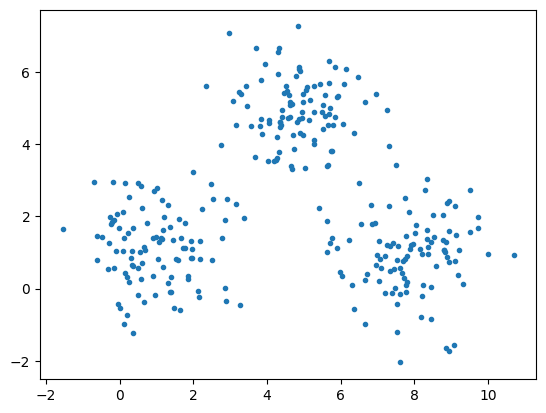

In [47]:
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

real_centers = [[1,1], [5,5], [8, 1]]
X, y = make_blobs(n_samples=300, centers=real_centers, n_features=2,
                   random_state=0,)

plt.scatter(X[:,0], X[:,1], marker='.')

#### Implement K-means
> Task: implement the fit and predict function of K-means class here.

In [48]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy

class KMeans(BaseEstimator, ClassifierMixin):

    def __init__(self, k=3, centers=None):
        self.k = k
        self.centers = centers

    def _predict(self, X, centers):
        # Calculate the pairwise distance between each sample in X and the centroids.
        # Write your code here
        distance = cdist(X, centers)
        return np.argmin(distance, axis=1)
        

    def predict(self, X, y=None):
        return self._predict(X, self.centers)

    def fit(self, X, y=None):
        k = self.k
        c = X.shape[1]
        if self.centers is None:
            mean = np.mean(X, axis = 0)
            std = np.std(X, axis = 0)
            self.centers = np.random.randn(k, c) * std + mean
        centers = self.centers
        centers_new = deepcopy(self.centers) # Store new centers

        error = -1

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0:
            # Predict clusters of each point using the current clusters
            # Write your code here
            clusters = self.predict(X, centers)
            
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center in 'centers_new'
            # Write your code here
            for i in range(k):
                centers_new[i] = np.mean(X[clusters == i], axis=0) 
                
            error = np.linalg.norm(centers_new - centers_old)
            centers = centers_new
        self.centers = centers_new
        return self

    def score(self, X, y=None):
        return 0


Let's visualize the clusters.

In [49]:
!pip3 install mlxtend


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


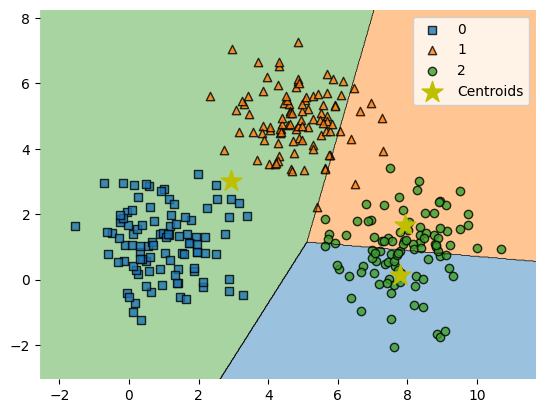

In [50]:
from mlxtend.plotting import plot_decision_regions

clf = KMeans(3, None).fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()

> Question: Run the previous cell several times and analyse the cluster assignments. What do you observe? Why?

### K-Means++

This algorithm is made to solve the problem of initial centroids values.

K-means++
1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute $D(x)$.
3. Choose the next centroid using a weighted probability distribution where a point x is chosen with probability proportional to  $𝐷(𝑥)^2$ .
4. Repeat until you have k points.

$D(x)$: the distance betweem x and the closest center

-----
### Task 2.

Implement K-means++ algorithm for selecting the intial points.

In [51]:
from numpy.random import choice

def choose(X, prob):
    # Return one point of X chosen randomly with probablity p
    # USE choice function in np.random (3 lines):
    idx = choice(X.shape[0], 1, p=prob)
    return X[idx]     

def kmeans_pp(X, k):
    n = X.shape[0]
    weights = np.ones(n) / n
    centers = []
    while len(centers) < k:
        # Choose a centroid with the current weights
        centroid = choose(X, weights)
        centers.extend(centroid)

        
        # Calculate the pair-wise distances
        # between the datapoints X and the current centers
        # get min distance then square it.
        # Obtain new probabilities in weights.
        
        # Write your code here
        distances = cdist(X, centers)
        min_dist = distances.min(axis=1)
        d_squared = min_dist**2
        weights = d_squared / d_squared.sum()
        
    return np.array(centers)

initial_centers = kmeans_pp(X, 3)
print(X.shape)

(300, 2)


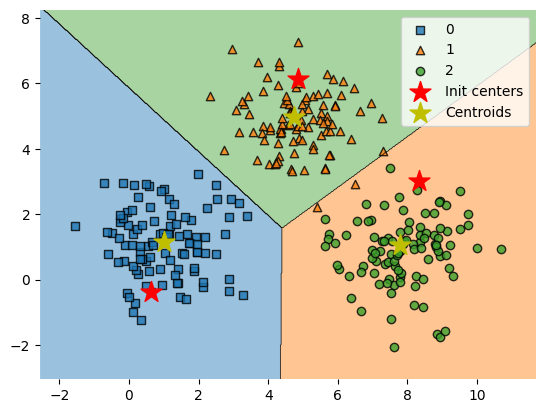

In [52]:
clf = KMeans(3, initial_centers).fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='*', c='red', s=250,label='Init centers')
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()

## Real world example of clustering 
The dataset is in the form of a 11463 x 5812 matrix of word counts, containing 11463 words and 5811 NIPS conference papers (the first column contains the list of words). Each column contains the number of times each word appears in the corresponding document. The names of the columns give information about each document and its timestamp in the following format: Xyear_paperID. We will use Kmeans on this dataset to identify papers related to the same topic (unknown).


#### Download the dataset

In [53]:
import requests
import os
import re
import pandas as pd 

# function used to download the dataset
def wget(url, filename = None):
    # allow redirects - in case file is relocated
    resp = requests.get(url, allow_redirects=True)
    # this can also be 2xx, but for simplicity now we stick to 200
    # you can also check for `resp.ok`
    if resp.status_code != 200:
        print(resp.status_code, resp.reason, 'for', url)
        return
    
    # try to extract filename from url
    if filename is None:
        # start with http*, ends if ? or # appears (or none of)
        m = re.search("^http.*/([^/\?#]*)[\?#]?", url)
        filename = m.group(1)
        if not filename:
            raise NameError(f"Filename neither given, nor found for {url}")

    # what will you do in case 2 websites store file with the same name?
    if os.path.exists(filename):
        raise OSError(f"File {filename} already exists")
    
    with open(filename, 'wb') as f:
        f.write(resp.content)
        print(f"File saved as {filename}")

In [54]:
# # Download this file from Moodle in case of any problem with the link
# dataset_name = "NIPS_1987-2015.csv"
# wget("https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv", dataset_name)

In [55]:
dataset_name = "NIPS_1987-2015.csv"
df = pd.read_csv(dataset_name)
df.head(5)

,Unnamed: 0,1987_1,1987_2,1987_3,1987_4,1987_5,1987_6,1987_7,1987_8,1987_9,...,2015_394,2015_395,2015_396,2015_397,2015_398,2015_399,2015_400,2015_401,2015_402,2015_403
0,abalone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abbeel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abbott,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abbreviate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,abbreviated,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# remove the first column
df = df.iloc[: , 1:] 

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Task 3.

Apply PCA with **2 components** on the dataset, train a Kmeans with **4 clusters** and plot the results.

c:\Users\hp\Desktop\Progs\ML\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\Desktop\Progs\ML\venv\lib\site-packages\mlxtend\plotting\decision_regions.py:300: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<AxesSubplot: >

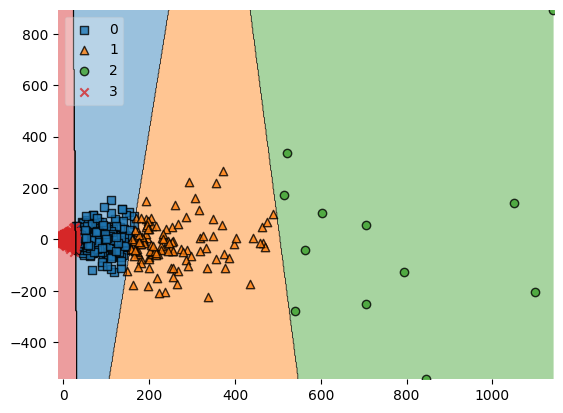

In [58]:
# Write your code here

# PCA training
pca = PCA(n_components=2)
X_tranformed = pca.fit_transform(df) 

# Visualization
kmeans = KMeans(n_clusters=4)
y_pred = kmeans.fit_predict(X_tranformed)
plot_decision_regions(X=X_tranformed, y=y_pred, clf=kmeans, legend=2)

> Question: In the previous task is there can you conclude on which value between 2 and 4 is best value for number of cluster $k$? Describe a problem where you can have an idea on the number clusters needed.
Complete the self-practice task to understand how to choose $k$ automatically

## When Kmeans is inefficient

Let's apply Kmean on the following datasets and interpret the results. First, complete the function `k_means_and_plot` to fit Kmeans and to visualize the results. Then, conclude on why Kmean does not work well on these datasets

In [59]:
def k_means_and_plot(X, y, k=2):
    initial_centers = kmeans_pp(X, k)
    clf = KMeans(k, initial_centers).fit(X,y)
    y_pred = clf.predict(X)
    plot_decision_regions(X=X, y=y_pred, clf=clf, legend=2)
    #plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='*', c='red', s=250,label='Init centers')
    plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
    plt.legend()

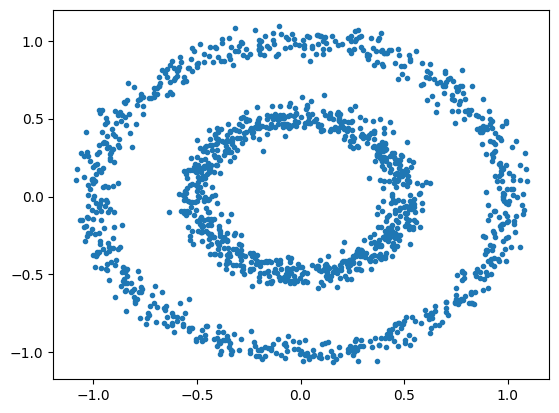

In [60]:
from sklearn.datasets import make_circles 
n_samples = 1500
X, y = make_circles(n_samples=n_samples, factor=.5, noise=.05)
plt.scatter(X[:,0], X[:,1], marker='.')

In [61]:
k_means_and_plot(X, y)

TypeError: KMeans.__init__() takes from 1 to 2 positional arguments but 3 were given

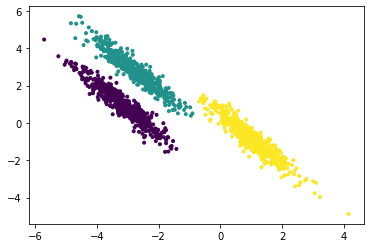

In [ ]:
# Anisotropicly distributed data
random_state = 170
X, y_aniso = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y_aniso)
plt.scatter(X_aniso[:,0], X_aniso[:,1], marker='.', c=y_aniso) 

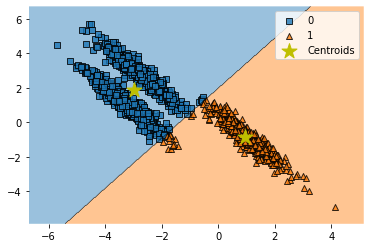

In [ ]:
k_means_and_plot(X_aniso, y_aniso)